In [12]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [13]:
# from google.colab import files
# import io
# uploaded = files.upload()
url='https://gist.githubusercontent.com/shreyasiitr/57f8fa30fa20b049359fb567cc6407d0/raw/20bd9bf2069e4a25790fbd17ea82828dad038291/AirQualityUCI.csv'
data=pd.read_csv(url)
data.head()

,Date,Time,CO,PT08S1,NMHC,C6H6,PT08S2,NOx,PT08S3,NO2,PT08S4,PT08S5,T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


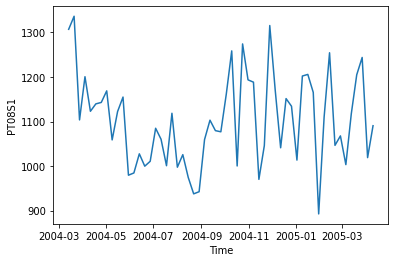

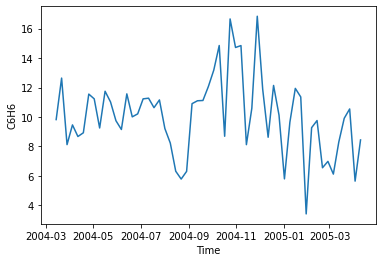

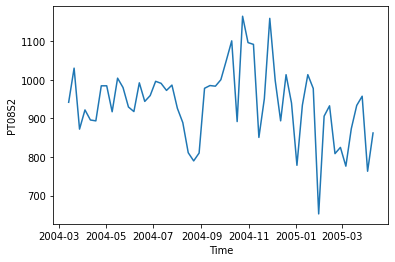

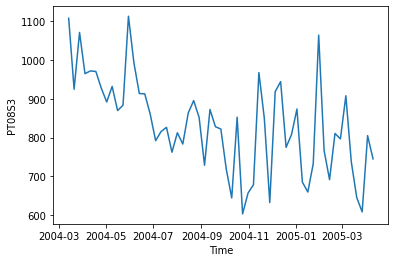

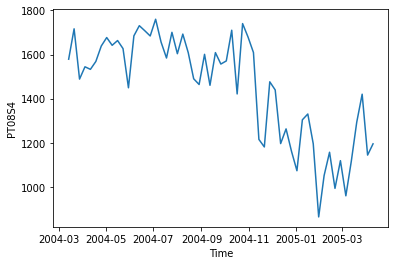

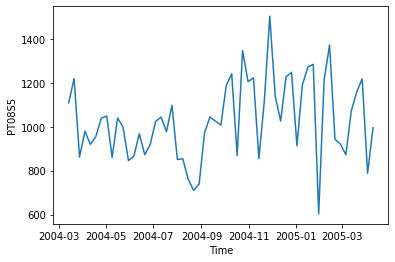

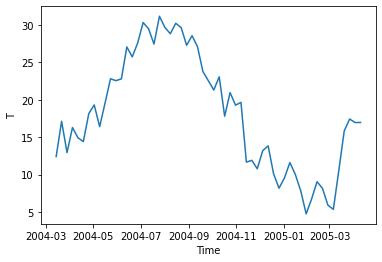

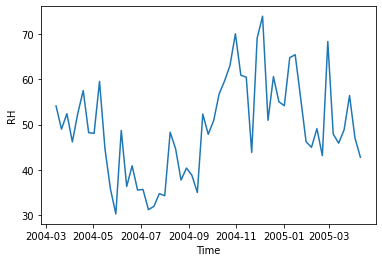

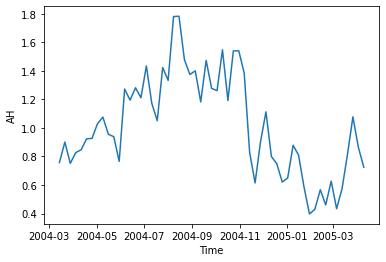

In [14]:
# Make dates actual dates
data['Date'] = pd.to_datetime(data['Date'])

# Convert measurements to floats
for col in data.iloc[:,2:].columns:
    if data[col].dtypes == object:
        data[col] = data[col].str.replace(',', '.').astype('float')

# Compute the average considering only the positive values
def positive_average(num):
    return num[num > -200].mean()
    
# Aggregate data
daily_data = data.drop('Time', axis=1).groupby('Date').apply(positive_average)

# Drop columns with more than 8 NaN
daily_data = daily_data.iloc[:,(daily_data.isna().sum() <= 8).values]

# Remove rows containing NaN values
daily_data = daily_data.dropna()

# Aggregate data by week
weekly_data = daily_data.resample('W').mean()

# Plot the weekly concentration of each gas
def plot_data(col):
    plt.plot(weekly_data[col])
    plt.xlabel('Time')
    plt.ylabel(col)
    plt.grid(False)
    plt.show()
    
for col in weekly_data.columns:
    plot_data(col)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


MAPE 8.7780710245411
MAE 63.216679816306936


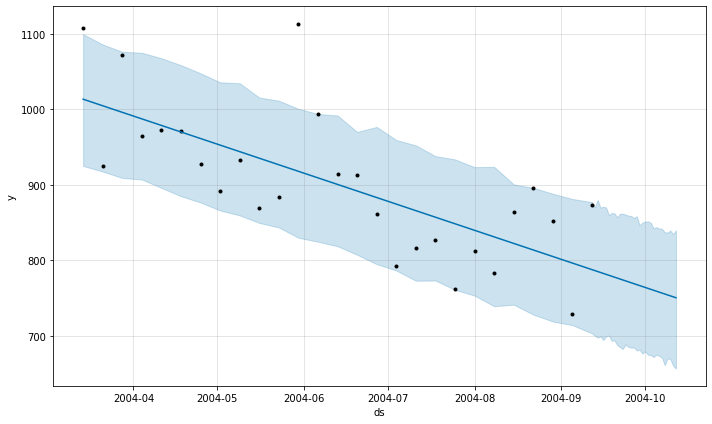

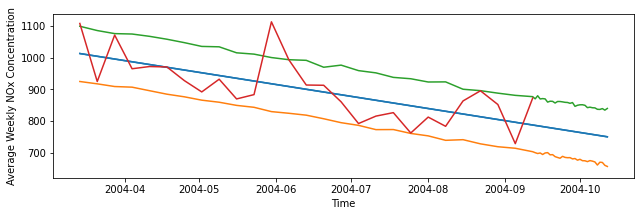

In [15]:

# Drop irrelevant columns
cols_to_drop = ['PT08S1', 'C6H6', 'PT08S2', 'PT08S4', 'PT08S5', 'T', 'RH', 'AH']

weekly_data = weekly_data.drop(cols_to_drop, axis=1)

# Import Prophet
from fbprophet import Prophet
import logging

logging.getLogger().setLevel(logging.ERROR)

# Change the column names according to Prophet's guidelines
df = weekly_data.reset_index()
df.columns = ['ds', 'y']
df.head()

# Split into a train/test set
prediction_size = 30
train_df = df[:-prediction_size]

# Initialize and train a model
m = Prophet()
m.fit(train_df)

# Make predictions
future = m.make_future_dataframe(periods=prediction_size)
forecast = m.predict(future)
forecast.head()

# Plot forecast
m.plot(forecast)

# Plot forecast's components
m.plot_components(forecast)

# Evaluate the model
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.head()

def calculate_forecast_errors(df, prediction_size):
    
    df = df.copy()
    
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    predicted_part = df[-prediction_size:]
    
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

# Plot forecast with upper and lower bounds

plt.plot(cmp_df['yhat'])
plt.plot(cmp_df['yhat_lower'])
plt.plot(cmp_df['yhat_upper'])
plt.plot(cmp_df['y'])
plt.xlabel('Time')
plt.ylabel('Average Weekly NOx Concentration')
plt.grid(False)
plt.show()